In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
from collections import defaultdict, deque

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import numpy as np
import pandas as pd
from glob import glob
import sys
sys.path.append('../src/')
from parsing import Parse
from training import TrainingOrders
from buildings import BuildOrders
datasetfolder = "i:/StarCraft_BO/replayActionList/*"
datasetfiles = glob(datasetfolder)

In [16]:
from buildings import protoss_buildings, zerg_buildings, terran_buildings
from training import protoss_units, zerg_units, terran_units

In [3]:
sc = Parse(datasetfiles[1])

In [6]:
sc.extract_training(1)[:10]

[('76', 'SCV'),
 ('1112', 'SCV'),
 ('1136', 'SCV'),
 ('1876', 'SCV'),
 ('2576', 'SCV'),
 ('4228', 'SCV'),
 ('4240', 'SCV'),
 ('4252', 'SCV'),
 ('4872', 'SCV'),
 ('6736', 'SCV')]

To cluster build orders, we will convert games into matrix of train/build frames for each units/buildings. The max queue to store can be a parameter. 
The distances between builds will be the average absolute differences. The dataset will be split into :  

|x|P|Z|T|
|-|-|-|-|
|P|PvP|PvZ|PvT|
|Z|ZvP|ZvZ|ZvT|
|T|TvP|TvZ|TvT|

In [80]:
bo_dict = {}
for race in ['Protoss','Zerg', 'Terran']:
    bo = BuildOrders(race,datasetfiles, nb_bo=100)
    b = bo.select_bo()
    b.extend(bo.select_bo(winners=False))
    bo_dict[race] = b

In [81]:
to_dict = {}
for race in ['Protoss','Zerg', 'Terran']:
    to = TrainingOrders(race, datasetfiles, nb_to=100)
    t = to.select_to()
    t.extend(to.select_to(winners=False))
    to_dict[race] = t

In [82]:
protoss_builds = []
for i,pb in enumerate(bo_dict['Protoss']):
    builds = {}
    for build in protoss_buildings:
        builds[build] = deque([0.0]*10, 10)
    for line in pb:
        builds[line[1]].appendleft(int(line[0]))
    a = pd.DataFrame.from_dict(builds)
    protoss_builds.append(a.values)

In [83]:
len(protoss_builds)

56

In [136]:
protoss_train =[]
for i,pt in enumerate(to_dict['Protoss']):
    trains = {}
    for unit in protoss_units:
        trains[unit] = deque([0.0]*10, 10)
    for line in pt:
        if line[1] in protoss_units and line[1] != 'Probe':
            trains[line[1]].appendleft(int(line[0]))
    a = pd.DataFrame.from_dict(trains)
    protoss_train.append(a.values)

### Distance matrix

In [137]:
train_mat = np.zeros((len(protoss_train), len(protoss_train)))
for i,a in enumerate(protoss_train):
    for j,b in enumerate(protoss_train):
        train_mat[i,j] = np.mean(np.abs(a - b))

In [138]:
train_mat

array([[    0.  ,  1043.38,  3368.7 , ..., 15251.64,  5160.22,   822.74],
       [ 1043.38,     0.  ,  3624.88, ..., 14596.82,  5025.52,   926.4 ],
       [ 3368.7 ,  3624.88,     0.  , ..., 12837.06,  8403.68,  3894.84],
       ...,
       [15251.64, 14596.82, 12837.06, ...,     0.  , 11646.58, 14661.02],
       [ 5160.22,  5025.52,  8403.68, ..., 11646.58,     0.  ,  4791.64],
       [  822.74,   926.4 ,  3894.84, ..., 14661.02,  4791.64,     0.  ]])

In [85]:
mat = np.zeros((len(protoss_builds), len(protoss_builds)))
for i,a in enumerate(protoss_builds):
    for j,b in enumerate(protoss_builds):
        mat[i,j] = np.mean(np.abs(a - b))

In [86]:
mat

array([[    0.        , 16076.66666667, 12485.49333333, ...,
        15661.09333333, 10341.97333333, 13888.88      ],
       [16076.66666667,     0.        ,  4046.32      , ...,
          415.57333333, 15741.14666667,  4740.10666667],
       [12485.49333333,  4046.32      ,     0.        , ...,
         3630.74666667, 12540.42666667,  5270.58666667],
       ...,
       [15661.09333333,   415.57333333,  3630.74666667, ...,
            0.        , 15325.57333333,  4406.29333333],
       [10341.97333333, 15741.14666667, 12540.42666667, ...,
        15325.57333333,     0.        , 11134.26666667],
       [13888.88      ,  4740.10666667,  5270.58666667, ...,
         4406.29333333, 11134.26666667,     0.        ]])

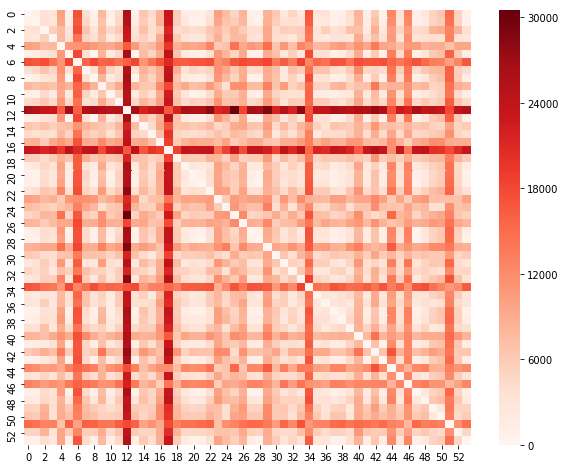

In [139]:
plt.figure(figsize=(10,8))
sns.heatmap(train_mat, cmap='Reds')
plt.show()

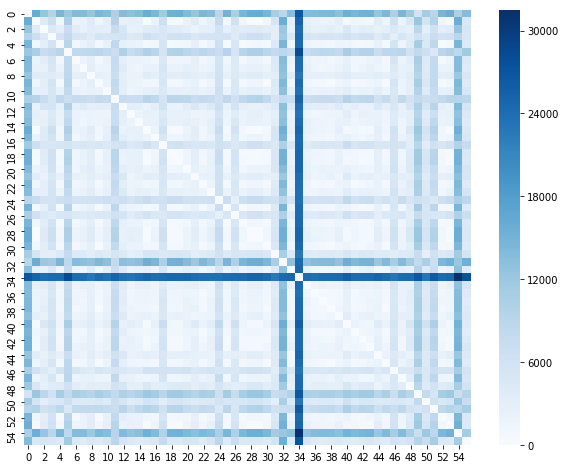

In [105]:
plt.figure(figsize=(10,8))
sns.heatmap(mat, cmap='Blues')
plt.show()

### Clusters

In [96]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [130]:
X = StandardScaler().fit_transform(mat)
db = DBSCAN().fit(X)

In [131]:
db.labels_

array([-1,  1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1,  0, -1,  0,  1,  1,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0,  1, -1, -1], dtype=int64)

In [132]:
np.where(db.labels_ == 0)

(array([ 4,  9, 25, 27, 30, 52], dtype=int64),)

In [133]:
np.where(db.labels_ == 1)[0]

array([ 1, 15, 19, 28, 29, 53], dtype=int64)

In [149]:
X = StandardScaler().fit_transform(train_mat)
db = DBSCAN(eps=0.8, min_samples=3).fit(X)

In [150]:
db.labels_

array([ 0,  0, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1,  0, -1,  0, -1, -1, -1,  0, -1, -1, -1,
       -1, -1,  0], dtype=int64)

In [151]:
np.where(db.labels_ == 0)

(array([ 0,  1, 20, 21, 27, 28, 37, 41, 43, 47, 53], dtype=int64),)

In [155]:
X

array([[-1.00211148, -0.82765496, -0.75600253, ...,  0.61718923,
        -0.48295443, -0.88998028],
       [-0.81789131, -1.01985079, -0.69735728, ...,  0.40264108,
        -0.51778017, -0.8709232 ],
       [-0.40733058, -0.35212972, -1.52717225, ..., -0.17393456,
         0.35561934, -0.32519871],
       ...,
       [ 1.69073271,  1.66895666,  1.41151388, ..., -4.37992629,
         1.19404832,  1.65407932],
       [-0.09101809, -0.09412481,  0.39661543, ..., -0.56398875,
        -1.817093  , -0.16032904],
       [-0.85684772, -0.84920327, -0.63555748, ...,  0.42367585,
        -0.57824819, -1.0412346 ]])